# `Automated script to download Sentinel-1 images using Alaska Satellite Facility API`


# Import libraries and packages

In [2]:
!apt-get install -y gdal-bin python3-gdal # Install GDAL system packages for geospatial data handling
!pip install asf_search # Install ASF Search library to query Sentinel-1 data from Alaska Satellite Facility
!pip install shapely # Install Shapely for geometric operations (bounding boxes, polygons)
!pip install rasterio # Install Rasterio for raster data reading/writing

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  libgdal-grass python-numpy-doc python3-dev python3-pytest
The following NEW packages will be installed:
  gdal-bin python3-gdal python3-numpy
0 upgraded, 3 newly installed, 0 to remove and 2 not upgraded.
Need to get 5,168 kB of archives.
After this operation, 25.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 python3-numpy amd64 1:1.21.5-1ubuntu22.04.1 [3,467 kB]
Get:2 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 python3-gdal amd64 3.8.4+dfsg-1~jammy0 [1,095 kB]
Get:3 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy/main amd64 gdal-bin amd64 3.8.4+dfsg-1~jammy0 [605 kB]
Fetched 5,168 kB in 5s (1,008 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 117540 files and directo

In [3]:
import asf_search as asf # Import ASF search library
from shapely.geometry import box, mapping # Import Shapely geometry tools to build bounding boxes and convert to WKT
from datetime import datetime, timezone # Import datetime utilities for defining search date ranges

# Import standard libraries for file handling and compression
import os
import zipfile

# Import rasterio for raster processing
import rasterio
import rasterio.mask

from google.colab import files # Import Colab utility to download files to local machine
import getpass # Import getpass for secure password input
import pyproj # Import pyproj for coordinate transformations
from shapely.ops import transform # Import Shapely transform for reprojection
import numpy as np # Import numpy for numerical operations
from rasterio import shutil as rio_shutil # Import rasterio shutil for file operations
from scipy.ndimage import uniform_filter # Import uniform_filter for local statistics (used in Lee filter)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Authenticate with Earthdata NASA

In [6]:
# --- Prompt for Earthdata credentials securely ---
username = input("Enter your Earthdata username: ")
password = getpass.getpass("Enter your Earthdata password: ")

# --- Authenticate with Earthdata credentials ---
session = asf.ASFSession().auth_with_creds(username, password)

Enter your Earthdata username: Carlosmendez1997
Enter your Earthdata password: ··········


# Define Area of Interest (AOI)

In [7]:
# --- Define bounding box coordinates ---
xmin, ymin, xmax, ymax = -68.803909, -11.033737, -68.725933, -10.979773

# --- Create shapely polygon and convert to WKT ---
bbox_geom = box(xmin, ymin, xmax, ymax)

# Define search parameters

In [9]:
# --- Define search parameters for Sentinel-1 ---
platform = "Sentinel-1A"          # Satellite platform
polarizations = ["VV", "VH"]      # Polarizations to include
beam_mode = "IW"                  # Interferometric Wide swath mode
processing_level = "GRD"          # Ground Range Detected products
orbit_direction = "DESCENDING"    # Orbit direction filter
relative_orbit = 127              # Relative orbit number

# Set date range

In [10]:
# --- Date range for search ---
start_date = "2026-01-01" # Start date
end_date = datetime.now(timezone.utc).strftime("%Y-%m-%d") # Current date

# Perform Search on ASF

In [11]:
# --- Perform search on ASF ---
results = asf.search(
    platform=platform,
    processingLevel=processing_level,
    beamMode=beam_mode,
    polarization=polarizations,
    relativeOrbit=relative_orbit,
    start=start_date,
    end=end_date,
    intersectsWith=bbox_geom.wkt
)

# --- Print number of scenes found ---
print(f"Found {len(results)} Sentinel-1 scenes")

Found 16 Sentinel-1 scenes


# Create folder to dowload data

In [12]:
# --- Create folder for downloads ---
os.makedirs("ASF_Sentinel1", exist_ok=True)
# --- Download results into folder ---
results.download(path="ASF_Sentinel1", session=session)

# Create output folder for GeoTIFFs

In [13]:
# --- Create output folder for processed GeoTIFFs ---
output_dir = "ASF_Sentinel1/GeoTIFFs"
os.makedirs(output_dir, exist_ok=True)

# Additional processing S1 images

## Lee speckle filter

In [14]:
# --- Define Lee speckle filter (adapted for complex data) ---
def lee_filter(src_path, out_path, size=7):
    with rasterio.open(src_path) as src:
        band = src.read(1)  # Read first band

        # If band contains complex values, convert to magnitude
        if np.iscomplexobj(band):
            band = np.abs(band)

        band = band.astype(np.float32)  # Ensure float32 type

        # Compute local mean and variance using moving window
        mean = uniform_filter(band, size=size)
        mean_sq = uniform_filter(band**2, size=size)
        variance = mean_sq - mean**2

        # Estimate global noise variance
        overall_variance = np.var(band)

        # Compute adaptive weight for Lee filter
        weight = variance / (variance + overall_variance)
        filtered = mean + weight * (band - mean)

        # Save filtered raster as float32
        profile = src.profile
        profile.update(dtype="float32")
        with rasterio.open(out_path, "w", **profile) as dst:
            dst.write(filtered.astype(np.float32), 1)

        print(f"Saved Lee-filtered raster: {out_path}")

## Process only .tiff files

In [15]:
# --- Process downloaded .tiff files ---
for root, dirs, files_in_dir in os.walk("ASF_Sentinel1"):
    for f in files_in_dir:
        if f.endswith(".tiff") and ("VV" in f or "VH" in f):
            src_path = os.path.join(root, f)
            try:
                date_str = f.split("_")[3][:8]  # Extract date from filename
            except Exception:
                date_str = "unknown"
            pol = "VV" if "VV" in f else "VH"  # Determine polarization
            out_name = f"S1_{pol}_{date_str}.tif"
            out_path = os.path.join(output_dir, out_name)

            # Copy raster directly (no clipping here)
            with rasterio.open(src_path) as src:
                profile = src.profile
                data = src.read()
                with rasterio.open(out_path, "w", **profile) as dst:
                    dst.write(data)
            print(f"Saved raster: {out_path}")

            # Apply Lee filter to raster
            lee_path = out_path.replace(".tif", "_lee.tif")
            lee_filter(out_path, lee_path)

Saved raster: ASF_Sentinel1/GeoTIFFs/S1_VV_20260126.tif


Saved Lee-filtered raster: ASF_Sentinel1/GeoTIFFs/S1_VV_20260126_lee.tif
Saved raster: ASF_Sentinel1/GeoTIFFs/S1_VH_20260108.tif


Saved Lee-filtered raster: ASF_Sentinel1/GeoTIFFs/S1_VH_20260108_lee.tif
Saved raster: ASF_Sentinel1/GeoTIFFs/S1_VV_20260102.tif


Saved Lee-filtered raster: ASF_Sentinel1/GeoTIFFs/S1_VV_20260102_lee.tif
Saved raster: ASF_Sentinel1/GeoTIFFs/S1_VH_20260207.tif


Saved Lee-filtered raster: ASF_Sentinel1/GeoTIFFs/S1_VH_20260207_lee.tif
Saved raster: ASF_Sentinel1/GeoTIFFs/S1_VH_20260126.tif


Saved Lee-filtered raster: ASF_Sentinel1/GeoTIFFs/S1_VH_20260126_lee.tif


Saved raster: ASF_Sentinel1/GeoTIFFs/S1_VH_20260102.tif


Saved Lee-filtered raster: ASF_Sentinel1/GeoTIFFs/S1_VH_20260102_lee.tif


Saved raster: ASF_Sentinel1/GeoTIFFs/S1_VV_20260108.tif


Saved Lee-filtered raster: ASF_Sentinel1/GeoTIFFs/S1_VV_20260108_lee.tif


Saved raster: ASF_Sentinel1/GeoTIFFs/S1_VV_20260207.tif


Saved Lee-filtered raster: ASF_Sentinel1/GeoTIFFs/S1_VV_20260207_lee.tif


## Visualize S1 images in AOI

TypeError: Image data of dtype complex128 cannot be converted to float

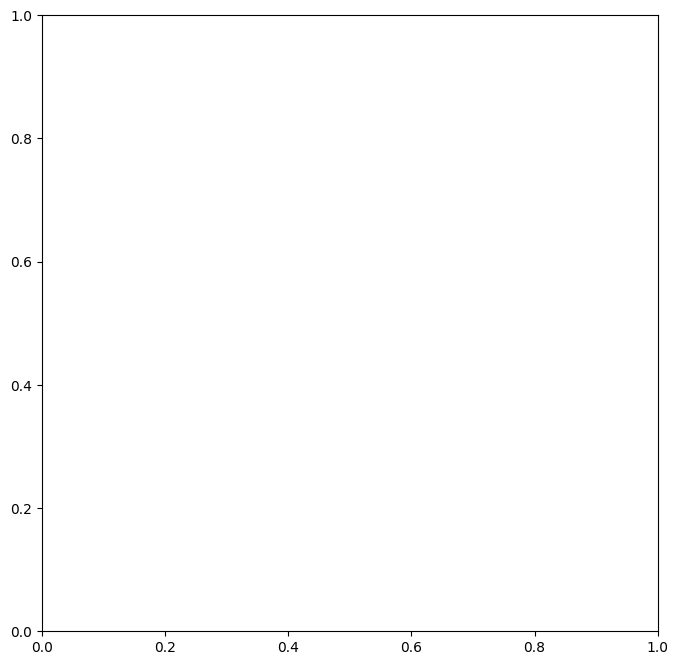

In [16]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from shapely.geometry import box
import geopandas as gpd

# Define AOI polygon
xmin, ymin, xmax, ymax = -68.803909, -11.033737, -68.725933, -10.979773
bbox_geom = box(xmin, ymin, xmax, ymax)
gdf = gpd.GeoDataFrame({"geometry":[bbox_geom]}, crs="EPSG:4326")

# Pick one raster to visualize
sample_file = "ASF_Sentinel1/GeoTIFFs/S1_VV_20260126.tif"

with rasterio.open(sample_file) as src:
    fig, ax = plt.subplots(figsize=(8,8))
    show(src, ax=ax, cmap="gray")  # Display raster
    gdf.boundary.plot(ax=ax, color="red", linewidth=2)  # Overlay AOI boundary
    ax.set_title("Raster with AOI overlay")
    plt.show()


# Compress all GeoTIFFs into a single ZIP

In [16]:
# --- Compress all GeoTIFFs into a single ZIP ---
zip_path = "ASF_Sentinel1/Sentinel1_GeoTIFFs.zip"
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for file in os.listdir(output_dir):
        file_path = os.path.join(output_dir, file)
        zipf.write(file_path, arcname=file)

print(f"Compressed file ready: {zip_path}")

✅ Compressed file ready: ASF_Sentinel1/Sentinel1_GeoTIFFs.zip


# Download ZIP to local machine

In [17]:
# --- Download ZIP to local machine ---
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>